In [16]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import gymnasium as gym
import torch
import numpy as np
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import pickle
import wandb

In [3]:
environment = "ALE/Breakout-v5"
bs = 32
replay_memory_size= 400_000 #replay memory max size
sync_every_n_steps = 10_000
gamma = 0.99
lr=0.0000625
epsilon = 1
final_epsilon = 0.1,
loss_fn = nn.SmoothL1Loss()
Optimizer = torch.optim.Adam
replay_start_size = 50_000
FRAMES_TO_TRAIN = 10_000_000
EPOCH_SIZE = 50_000
BASE_MODEL = None
final_exploration_frame = 1_000_000
MIN_STACK_SIZE = 4
max_grad_norm = 10
adam_epsilon = 1.5e-4
replay_period = 4

In [4]:
config = {
    "learning_rate": lr,
    "architecture": "DQN-Deepmind-2015",
    "environment": environment,
    "epsilon": epsilon,
    "final_epsilon": final_epsilon,
    "gamma":gamma,
    "bs":bs,
    "replay_memory_size":replay_memory_size,
    "sync_every_n_steps": sync_every_n_steps,
    "loss": str(loss_fn),
    "Optimizer": Optimizer.__name__,
    "frames_to_train": FRAMES_TO_TRAIN,
    "epoch_size":EPOCH_SIZE,
    "base_model": BASE_MODEL,
    "final_exploration_frame":final_exploration_frame,
    "replay_start_size":replay_start_size,
    "max_grad_norm":max_grad_norm,
    "adam_epsilon":adam_epsilon,
    "replay_period":replay_period
    }

In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="atari",
    
    # track hyperparameters and run metadata
    config=config
)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
class TorchEnv:
    def __init__(self, env: gym.Env, transforms=None, terminate_after_lose_life=True, image_listener=None):
        self.env = env
        self.n_observations = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        self.transforms = transforms
        self.terminate_after_lose_life = terminate_after_lose_life
        self.image_listener = image_listener
        

    def step(self, a):
        s, r, terminated, _, info = self.env.step(a)
        r = np.clip(r, -1, 1) # clip rewards between -1 and 1 as per DeepMind

        if self.image_listener:
            self.image_listener(s)

        # terminate if we lose a life as per Rainbow
        # https://arxiv.org/pdf/1710.02298.pdf
        if self.lives != info['lives'] and self.terminate_after_lose_life:
            terminated = True
        
        if self.transforms:
            s = s[None, :, :, :] # HWC -> BCHW
            s = self.transforms(s)
        return s, r, terminated

    def reset(self, *args, **kwargs):
        s, info = self.env.reset(*args, **kwargs)
        if self.image_listener:
            self.image_listener(s)
        self.lives = info['lives']
    
        # at episode start, repeat and stack the first state 4 times
        stack = [s]
        stack = np.vstack([s[None, :, :, :]] * MIN_STACK_SIZE) # HWC -> BHWC
        
        if self.transforms:
            stack = self.transforms(stack)
        
        return stack

    def close(self):
        return self.env.close()
    
    def sample(self):
        return np.random.randint(self.n_actions)

env = TorchEnv(gym.make(environment))

In [18]:
class ImageListener:
    def __init__(self, name):
        self.name = name
        self.images = []

    def __call__(self, img):
        self.images.append(img)

## Breakout

### Preprocessing

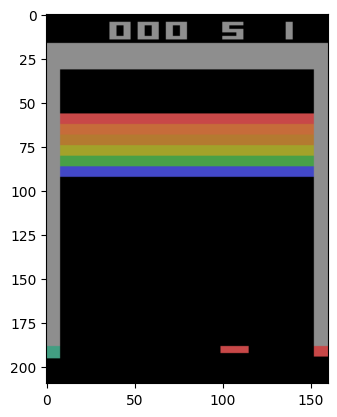

In [19]:
env = TorchEnv(gym.make(environment))
stack = env.reset() 
plt.imshow(stack[1])

#### Greyscale

In [20]:
class BatchGrayscale:
    def __init__(self):
        self.transforms = transforms.Grayscale()

    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, H, W, C)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        grey_pt_stack = torch.stack([self.transforms(s.permute(2,0,1)) for s in batch])
        return grey_pt_stack

In [21]:
def imglistshow(v_slice):
    plt.figure()
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,4) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(v_slice[0])
    axarr[1].imshow(v_slice[1])
    axarr[2].imshow(v_slice[2])
    axarr[3].imshow(v_slice[3])

<Figure size 640x480 with 0 Axes>

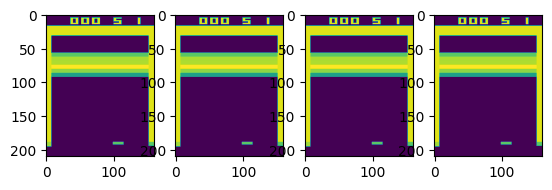

In [22]:
greyscale = BatchGrayscale() #transforms to grayscale
pt_stack = torch.from_numpy(stack).to(device)
img_stack = greyscale(pt_stack)
imglistshow(img_stack.squeeze(1))

In [23]:
class BatchDownsample:
    def __init__(self, size=(110,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        orig_dtype = batch.dtype
        result = nn.functional.interpolate(batch.float(), size=self.size,  mode='bilinear')
        return result.type(orig_dtype)

<Figure size 640x480 with 0 Axes>

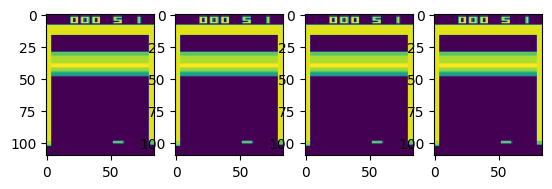

In [24]:
batch_downsample = BatchDownsample(size=(110,84))
downsampled_stack = batch_downsample(img_stack)
imglistshow(downsampled_stack.squeeze(1))

In [25]:
class BatchCrop:
    def __init__(self, size=(84,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """ crop 17 pixels from top and bottom
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        return batch[:, :,  17:17+self.size[0], :] # crop 17 pixels from top and bottom

<Figure size 640x480 with 0 Axes>

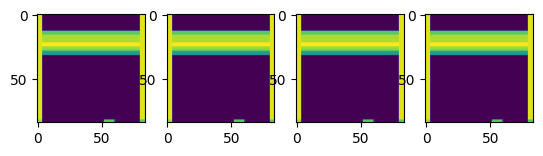

In [26]:
batch_downsample = BatchCrop(size=(84,84))
batch_downsample = batch_downsample(downsampled_stack)
imglistshow(batch_downsample.squeeze(1))

In [27]:
class BatchToTensor:
    def __init__(self, device):
        self.device = device

    def __call__(self, batch: np.array):
        """
        Args:
            batch (np.array): expects a numpy array
        Returns:
            torch.Tensor: torch tensor on device
        """
        return torch.from_numpy(batch).to(self.device)

In [28]:
class TransformPipeline:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, batch: torch.Tensor):
        for transform in self.transforms:
            batch = transform(batch)
        return batch

In [29]:
pipeline = TransformPipeline([BatchToTensor(device), BatchGrayscale(), BatchDownsample(), BatchCrop()])

In [33]:
def test_should_preprocess_to_correct_shape():   
    pipeline = TransformPipeline([BatchToTensor(device), BatchGrayscale(), BatchDownsample(), BatchCrop()]) 
    env = TorchEnv(gym.make(environment))
    s = env.reset()
    preprocessed_s_prime = pipeline(s)
    assert preprocessed_s_prime.shape == (4,1,84,84) # 4 frames, 1 channel, 84x84

test_should_preprocess_to_correct_shape()

## fill replay memory
here we fill the replay memory with downsampled cropped stacks

In [47]:
class ExperienceReplay:
    def __init__(self, maxlen: int) -> None:
        self.deque = deque(maxlen=maxlen)
        self.maxlen = maxlen

    def append(self, x: tuple)-> None:
        self.deque.append(x)

    def sample(self, bs: int) -> list:
        return random.sample(self.deque, min(len(self), bs))

    def __len__(self) -> int:
        return len(self.deque)
    
    @classmethod
    def load(cls, path: str):
        with open(path, 'rb') as f:
            return pickle.load(f)
        
    def save(self, path: str):
        with open(path, 'wb') as f:
            return pickle.dump(self, f)

def fill(replay_memory:ExperienceReplay, env:TorchEnv, fill_size:int = replay_start_size) -> None :
    while len(replay_memory)<fill_size:
        s = env.reset()
        terminated=False
        while terminated == False and len(replay_memory)<fill_size:
            a = env.sample()
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            s = s_prime

In [48]:
env = TorchEnv(gym.make(environment), transforms=pipeline)
replay_memory = ExperienceReplay(replay_memory_size)
fill(replay_memory, env, fill_size=10)
samples = replay_memory.sample(3)
s, a, r, s_prime, terminated = samples[0]
s.shape

torch.Size([4, 1, 84, 84])

<Figure size 640x480 with 0 Axes>

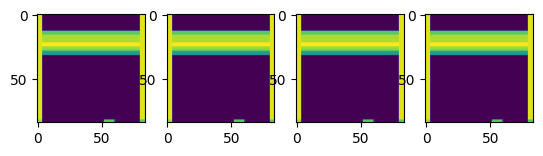

In [36]:
imglistshow(s.squeeze(1).cpu())

In [22]:
wandb.Image(s[:2].cpu(), caption="Top: Frame at t , Bottom: Frame at t+1")

In [88]:
# Memory Efficient Replay Memory
def low_mem_collate(batch):
    s_j, a_j, r_j, s_prime_j, terminated_j = batch
    return (s_j.squeeze(2).to(device), 
            a_j.to(device), 
            r_j.to(device), 
            s_prime_j.squeeze(2).to(device), 
            (~terminated_j).to(device).half()
           )
samples = replay_memory.sample(3)
s_j, a_j, r_j, s_prime_j, terminated_j = low_mem_collate(samples)
imglistshow(s_j[0].cpu())

## Define the Atari DQN

In [37]:
class DQNDeepmind2013(nn.Module):
    def __init__(self, n_actions):
        super(DQNDeepmind2013, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 16, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*9*9, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        
    def forward(self, s):
        return self.conv(s) 
    
class DQNDeepmind2015(nn.Module):
    def __init__(self, n_actions):
        super(DQNDeepmind2015, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def forward(self, s):
        return self.conv(s) 

In [38]:
class AtariDQN(nn.Module):
    def __init__(self, net, n_actions, normalize=True):
        super(AtariDQN, self).__init__()
        self.net = net
        self.n_actions = n_actions
        self.normalize = normalize

    def forward(self, s: torch.Tensor):
        '''
        Args:
            s (torch.Tensor): batch of shape (B, H, W)
        Returns:
            torch.Tensor: batch of shape (B, n_actions)
        '''
        if self.normalize:
            s = s.float() / 255.0
        return self.net(s)

    def select_next_action(self, s, epsilon):
        with torch.no_grad():
            use_greedy = np.random.binomial(1, 1-epsilon)
            if use_greedy:
                a = self(s).argmax().item()
            else:
                a = np.random.randint(self.n_actions)
            return a

# Train Network

In [39]:
dqn = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
if BASE_MODEL is not None:
    print(f"Loading base model from {BASE_MODEL}")
    dqn.load_state_dict(torch.load(BASE_MODEL))

target_net = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
target_net.load_state_dict(dqn.state_dict())

<All keys matched successfully>

In [42]:
def test_should_return_value_for_each_action():
    n_actions = 4
    dqn = AtariDQN(DQNDeepmind2015(n_actions), n_actions=n_actions)
    samples = torch.randn(32, 4, 1, 84, 84)
    out = dqn(samples[0].squeeze(1).unsqueeze(0)).squeeze(0)
    assert out.shape[0] == env.n_actions

test_should_return_value_for_each_action()

In [43]:
optimizer = Optimizer(dqn.parameters(),  lr=lr, eps=adam_epsilon)
dqn.train()

AtariDQN(
  (net): DQNDeepmind2015(
    (conv): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3136, out_features=512, bias=True)
      (8): ReLU()
      (9): Linear(in_features=512, out_features=4, bias=True)
    )
  )
)

In [44]:
def atari_collate(batch):
    s_j, a_j, r_j, s_prime_j, terminated_j = list(zip(*batch))
    return (torch.stack(s_j).squeeze(2).to(device), 
            torch.tensor(a_j).to(device), 
            torch.tensor(r_j).to(device), 
            torch.stack(s_prime_j).squeeze(2).to(device), 
            (~torch.tensor(terminated_j)).to(device).half()
    )
def get_batch_efficient(self, batch, target_net=None, collate_fn=None):
    if target_net is None:
        target_net = self
    s, a, r, s_prime, not_terminated = collate_fn(batch)

    y_hat = self(s).gather(1, a.unsqueeze(1)).squeeze() # gather the values at the indices given by the actions a

    next_values, _ = target_net(s_prime).max(dim=1)
    next_values = next_values.clone().detach()
    y_j = r.detach().clone() + gamma * next_values * not_terminated # if terminated then not_terminated is set to zero (y_j = r)
    return y_hat, y_j

def get_epsilon(epsilon, final_epsilon=0.1, steps_to_anneal=final_exploration_frame):
    if epsilon > final_epsilon:
        epsilon -= (1/steps_to_anneal) * (1-final_epsilon)
    return epsilon

In [45]:
def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.1)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

validate(dqn, env)

0.05421686746987952

In [344]:
n_epochs = FRAMES_TO_TRAIN // EPOCH_SIZE
print(n_epochs)
track = True
for epoch in range(n_epochs):
    epoch_loss, epoch_reward, k, epoch_episodes = 0, 0, 0, 0
    while k < EPOCH_SIZE:
        terminated = False
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), epsilon)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            epsilon = get_epsilon(epsilon)
            s = s_prime

            if len(replay_memory) > replay_start_size and k % replay_period == 0:
                optimizer.zero_grad()
                batch = replay_memory.sample(bs)
                y_hat, y = get_batch_efficient(dqn, batch, target_net=target_net, collate_fn=atari_collate)
                loss = loss_fn(y_hat, y)
                loss.backward()
                torch.nn.utils.clip_grad_value_(dqn.parameters(), max_grad_norm)
                optimizer.step()
                        
                if k % sync_every_n_steps == 0:
                    target_net.load_state_dict(dqn.state_dict())
            
                loss = loss.detach()
                epoch_loss += loss.item()
            epoch_reward += r
            k += 1
        epoch_episodes += 1
    
    if track:
        validate_reward = validate(dqn, env)
        torch.save(dqn.state_dict(), 'breakout.pt')
        wandb.log_model(name=f"breakout-{wandb.run.id}", path='breakout.pt')
        wandb.log({"epoch":epoch,
                "step_loss": epoch_loss / k, 
                "reward": epoch_reward / epoch_episodes,
                "step":k,
                "epsilon": epsilon,
                "validate_reward":validate_reward
                })
        print(f'epochs {epoch}, step_loss {epoch_loss / k}, reward {epoch_reward / epoch_episodes}, k {k}, epsilon {epsilon}')
env.close()

200

In [46]:
replay_memory.save('replay_memory.pkl')

TypeError: dump() missing required argument 'file' (pos 2)

In [144]:

env = TorchEnv(gym.make(environment), transforms=pipeline, terminate_after_lose_life=False)
dqn = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
dqn.load_state_dict(torch.load('breakout (26).pt', map_location=torch.device('cpu')))

def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.1)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

validate(dqn, env)

22.0

In [302]:
wandb.finish()

epoch,▁▃▆█
epsilon,█▆▃▁
reward,▁█▃█
step,█▄▁█
step_loss,█▂▁▁
epoch,3
epsilon,0.99636
reward,1.5283
step,10160
step_loss,0.00035


In [142]:
WRITERS["opencv"](iter(env.images), "breakout-26.mp4")

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [119]:
import shutil
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Iterator, Literal, Optional

import cv2
import ffmpeg
import matplotlib.animation as ani
import matplotlib.pyplot as plt
import numpy as np


def as_uint8(arr: np.ndarray) -> np.ndarray:
    if np.issubdtype(arr.dtype, np.integer):
        return arr.astype(np.uint8)
    if np.issubdtype(arr.dtype, np.floating):
        return (arr * 255).round().astype(np.uint8)
    raise NotImplementedError(f"Unsupported dtype: {arr.dtype}")


@dataclass
class VideoProps:
    frame_width: int
    frame_height: int
    frame_count: int
    fps: int

    @classmethod
    def from_file_opencv(cls, fpath: str) -> "VideoProps":
        cap = cv2.VideoCapture(str(fpath))

        return cls(
            frame_width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            frame_height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
            frame_count=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
            fps=int(cap.get(cv2.CAP_PROP_FPS)),
        )

    @classmethod
    def from_file_ffmpeg(cls, fpath: str) -> "VideoProps":
        probe = ffmpeg.probe(str(fpath))

        for stream in probe["streams"]:
            if stream["codec_type"] == "video":
                width, height, count = stream["width"], stream["height"], int(stream["nb_frames"])
                fps_num, fps_denom = stream["r_frame_rate"].split("/")
                assert fps_denom == "1", f"Unexpected frame rate: {stream['r_frame_rate']}"
                fps = int(fps_num)
                return cls(
                    frame_width=width,
                    frame_height=height,
                    frame_count=count,
                    fps=fps,
                )

        raise ValueError(f"Could not parse video properties from video in {fpath}")


def read_video_ffmpeg(
    in_file: str,
    output_fmt: str = "rgb24",
    channels: int = 3,
) -> Iterator[np.ndarray]:
    """Function that reads a video to a stream of numpy arrays using FFMPEG.

    Args:
        in_file: The input video to read
        output_fmt: The output image format
        channels: Number of output channels for each video frame

    Yields:
        Frames from the video as numpy arrays with shape (H, W, C)
    """

    props = VideoProps.from_file_ffmpeg(in_file)

    stream = ffmpeg.input(str(in_file))
    stream = ffmpeg.output(stream, "pipe:", format="rawvideo", pix_fmt=output_fmt, r=props.fps)
    stream = ffmpeg.run_async(stream, pipe_stdout=True)

    while True:
        in_bytes = stream.stdout.read(props.frame_width * props.frame_height * channels)
        if not in_bytes:
            break
        yield np.frombuffer(in_bytes, np.uint8).reshape((props.frame_height, props.frame_width, channels))

    stream.stdout.close()
    stream.wait()


def read_video_opencv(in_file: str) -> Iterator[np.ndarray]:
    """Reads a video as a stream using OpenCV.

    Args:
        in_file: The input video to read

    Yields:
        Frames from the video as numpy arrays with shape (H, W, C)
    """

    cap = cv2.VideoCapture(str(in_file))

    while True:
        ret, buffer = cap.read()
        if not ret:
            cap.release()
            return
        yield buffer


def write_video_opencv(
    itr: Iterator[np.ndarray],
    out_file: str,
    fps: int = 30,
    codec: str = "MP4V",
) -> None:
    """Function that writes a video from a stream of numpy arrays using OpenCV.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        fps: Frames per second for the video.
        codec: FourCC code specifying OpenCV video codec type. Examples are
            MPEG, MP4V, DIVX, AVC1, H236.
    """

    first_img = next(itr)
    height, width, _ = first_img.shape

    fourcc = cv2.VideoWriter_fourcc(*codec)
    stream = cv2.VideoWriter(str(out_file), fourcc, fps, (width, height))

    def write_frame(img: np.ndarray) -> None:
        stream.write(as_uint8(img))

    write_frame(first_img)
    for img in itr:
        write_frame(img)

    stream.release()
    cv2.destroyAllWindows()


def write_video_ffmpeg(
    itr: Iterator[np.ndarray],
    out_file: str,
    fps: int = 30,
    out_fps: int = 30,
    vcodec: str = "libx264",
    input_fmt: str = "rgb24",
    output_fmt: str = "yuv420p",
) -> None:
    """Function that writes an video from a stream of numpy arrays using FFMPEG.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        fps: Frames per second for the video.
        out_fps: Frames per second for the saved video.
        vcodec: The video codec to use for the output video
        input_fmt: The input image format
        output_fmt: The output image format
    """

    first_img = next(itr)
    height, width, _ = first_img.shape

    stream = ffmpeg.input("pipe:", format="rawvideo", pix_fmt=input_fmt, s=f"{width}x{height}", r=fps)
    stream = ffmpeg.output(stream, str(out_file), pix_fmt=output_fmt, vcodec=vcodec, r=out_fps)
    stream = ffmpeg.overwrite_output(stream)
    stream = ffmpeg.run_async(stream, pipe_stdin=True)

    def write_frame(img: np.ndarray) -> None:
        stream.stdin.write(as_uint8(img).tobytes())

    # Writes all the video frames to the file.
    write_frame(first_img)
    for img in itr:
        write_frame(img)

    stream.stdin.close()
    stream.wait()


def write_video_matplotlib(
    itr: Iterator[np.ndarray],
    out_file: str,
    dpi: int = 50,
    fps: int = 30,
    title: str = "Video",
    comment: Optional[str] = None,
    writer: str = "ffmpeg",
) -> None:
    """Function that writes an video from a stream of input tensors.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        dpi: Dots per inch for output image.
        fps: Frames per second for the video.
        title: Title for the video metadata.
        comment: Comment for the video metadata.
        writer: The Matplotlib video writer to use (if you use the
            default one, make sure you have `ffmpeg` installed on your
            system).
    """

    first_img = next(itr)
    height, width, _ = first_img.shape
    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi))

    # Ensures that there's no extra space around the image.
    fig.subplots_adjust(
        left=0,
        bottom=0,
        right=1,
        top=1,
        wspace=None,
        hspace=None,
    )

    # Creates the writer with the given metadata.
    writer_obj = ani.writers[writer]
    metadata = {
        "title": title,
        "artist": __name__,
        "comment": comment,
    }
    mpl_writer = writer_obj(
        fps=fps,
        metadata={k: v for k, v in metadata.items() if v is not None},
    )

    with mpl_writer.saving(fig, out_file, dpi=dpi):
        im = ax.imshow(as_uint8(first_img), interpolation="nearest")
        mpl_writer.grab_frame()

        for img in itr:
            im.set_data(as_uint8(img))
            mpl_writer.grab_frame()


Reader = Literal["ffmpeg", "opencv"]
Writer = Literal["ffmpeg", "matplotlib", "opencv"]

READERS: Dict[Reader, Callable[[str], Iterator[np.ndarray]]] = {
    "ffmpeg": read_video_ffmpeg,
    "opencv": read_video_opencv,
}

WRITERS: Dict[Writer, Callable[[Iterator[np.ndarray], str], None]] = {
    "ffmpeg": write_video_ffmpeg,
    "matplotlib": write_video_matplotlib,
    "opencv": write_video_opencv,
}

# Remove the FFMPEG reader and writer if FFMPEG is not available in the system.
if not shutil.which("ffmpeg"):
    READERS.pop("ffmpeg")
    WRITERS.pop("ffmpeg")
    WRITERS.pop("matplotlib")


In [184]:
a_zero_count = 0
s = env.reset(seed=42)
Q = dqn(s.permute(2, 0, 1).unsqueeze(0))
print(Q)
a = Q.argmax().item()
terminated = False
while terminated==False:
    s_prime, r, terminated =  env.step(a)
    print(r)
    s_prime = preprocess(s_prime)
    s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]
    s = s_prime
    Q = dqn(s.permute(2, 0, 1).unsqueeze(0))
    a = Q.argmax().item()
    
    
    print(Q)

tensor([[3.1331, 3.1186, 3.1245, 3.1267]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.1724, 3.1563, 3.1611, 3.1671]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.1482, 3.1338, 3.1381, 3.1462]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.1731, 3.1577, 3.1627, 3.1705]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.1512, 3.1224, 3.1316, 3.1465]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.0785, 3.0421, 3.0541, 3.0791]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.2077, 3.1701, 3.1721, 3.2142]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.3163, 3.2706, 3.2784, 3.3198]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.3963, 3.3538, 3.3632, 3.3897]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.3996, 3.3793, 3.3913, 3.3810]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.2257, 3.2033, 3.2087, 3.2306]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.2619, 3.2486, 3.2538, 3.2515]], grad_fn=<AddmmBackward0>)
tensor(0.)
tensor([[3.2966, 3.2778, 3.2878, 3.2812]

In [38]:
images = []
s = env.reset(seed=42)
terminated=False
while terminated == False:
    a = dqn.select_next_action(s.permute(2, 0, 1).unsqueeze(0).float(), 0.1)
    s_prime, r, terminated = env.step(a)
    images.append(s_prime.clone().long().numpy())
    s_prime = preprocess(s_prime)
    s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]
    s = s_prime

In [41]:
WRITERS["opencv"](iter(images), "test.mp4")

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [47]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 4.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [40]:
import shutil
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, Iterator, Literal, Optional

import cv2
import ffmpeg
import matplotlib.animation as ani
import matplotlib.pyplot as plt
import numpy as np


def as_uint8(arr: np.ndarray) -> np.ndarray:
    if np.issubdtype(arr.dtype, np.integer):
        return arr.astype(np.uint8)
    if np.issubdtype(arr.dtype, np.floating):
        return (arr * 255).round().astype(np.uint8)
    raise NotImplementedError(f"Unsupported dtype: {arr.dtype}")


@dataclass
class VideoProps:
    frame_width: int
    frame_height: int
    frame_count: int
    fps: int

    @classmethod
    def from_file_opencv(cls, fpath: str) -> "VideoProps":
        cap = cv2.VideoCapture(str(fpath))

        return cls(
            frame_width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            frame_height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
            frame_count=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
            fps=int(cap.get(cv2.CAP_PROP_FPS)),
        )

    @classmethod
    def from_file_ffmpeg(cls, fpath: str) -> "VideoProps":
        probe = ffmpeg.probe(str(fpath))

        for stream in probe["streams"]:
            if stream["codec_type"] == "video":
                width, height, count = stream["width"], stream["height"], int(stream["nb_frames"])
                fps_num, fps_denom = stream["r_frame_rate"].split("/")
                assert fps_denom == "1", f"Unexpected frame rate: {stream['r_frame_rate']}"
                fps = int(fps_num)
                return cls(
                    frame_width=width,
                    frame_height=height,
                    frame_count=count,
                    fps=fps,
                )

        raise ValueError(f"Could not parse video properties from video in {fpath}")


def read_video_ffmpeg(
    in_file: str,
    output_fmt: str = "rgb24",
    channels: int = 3,
) -> Iterator[np.ndarray]:
    """Function that reads a video to a stream of numpy arrays using FFMPEG.

    Args:
        in_file: The input video to read
        output_fmt: The output image format
        channels: Number of output channels for each video frame

    Yields:
        Frames from the video as numpy arrays with shape (H, W, C)
    """

    props = VideoProps.from_file_ffmpeg(in_file)

    stream = ffmpeg.input(str(in_file))
    stream = ffmpeg.output(stream, "pipe:", format="rawvideo", pix_fmt=output_fmt, r=props.fps)
    stream = ffmpeg.run_async(stream, pipe_stdout=True)

    while True:
        in_bytes = stream.stdout.read(props.frame_width * props.frame_height * channels)
        if not in_bytes:
            break
        yield np.frombuffer(in_bytes, np.uint8).reshape((props.frame_height, props.frame_width, channels))

    stream.stdout.close()
    stream.wait()


def read_video_opencv(in_file: str) -> Iterator[np.ndarray]:
    """Reads a video as a stream using OpenCV.

    Args:
        in_file: The input video to read

    Yields:
        Frames from the video as numpy arrays with shape (H, W, C)
    """

    cap = cv2.VideoCapture(str(in_file))

    while True:
        ret, buffer = cap.read()
        if not ret:
            cap.release()
            return
        yield buffer


def write_video_opencv(
    itr: Iterator[np.ndarray],
    out_file: str,
    fps: int = 30,
    codec: str = "MP4V",
) -> None:
    """Function that writes a video from a stream of numpy arrays using OpenCV.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        fps: Frames per second for the video.
        codec: FourCC code specifying OpenCV video codec type. Examples are
            MPEG, MP4V, DIVX, AVC1, H236.
    """

    first_img = next(itr)
    height, width, _ = first_img.shape

    fourcc = cv2.VideoWriter_fourcc(*codec)
    stream = cv2.VideoWriter(str(out_file), fourcc, fps, (width, height))

    def write_frame(img: np.ndarray) -> None:
        stream.write(as_uint8(img))

    write_frame(first_img)
    for img in itr:
        write_frame(img)

    stream.release()
    cv2.destroyAllWindows()


def write_video_ffmpeg(
    itr: Iterator[np.ndarray],
    out_file: str,
    fps: int = 30,
    out_fps: int = 30,
    vcodec: str = "libx264",
    input_fmt: str = "rgb24",
    output_fmt: str = "yuv420p",
) -> None:
    """Function that writes an video from a stream of numpy arrays using FFMPEG.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        fps: Frames per second for the video.
        out_fps: Frames per second for the saved video.
        vcodec: The video codec to use for the output video
        input_fmt: The input image format
        output_fmt: The output image format
    """

    first_img = next(itr)
    height, width, _ = first_img.shape

    stream = ffmpeg.input("pipe:", format="rawvideo", pix_fmt=input_fmt, s=f"{width}x{height}", r=fps)
    stream = ffmpeg.output(stream, str(out_file), pix_fmt=output_fmt, vcodec=vcodec, r=out_fps)
    stream = ffmpeg.overwrite_output(stream)
    stream = ffmpeg.run_async(stream, pipe_stdin=True)

    def write_frame(img: np.ndarray) -> None:
        stream.stdin.write(as_uint8(img).tobytes())

    # Writes all the video frames to the file.
    write_frame(first_img)
    for img in itr:
        write_frame(img)

    stream.stdin.close()
    stream.wait()


def write_video_matplotlib(
    itr: Iterator[np.ndarray],
    out_file: str,
    dpi: int = 50,
    fps: int = 30,
    title: str = "Video",
    comment: Optional[str] = None,
    writer: str = "ffmpeg",
) -> None:
    """Function that writes an video from a stream of input tensors.

    Args:
        itr: The image iterator, yielding images with shape (H, W, C).
        out_file: The path to the output file.
        dpi: Dots per inch for output image.
        fps: Frames per second for the video.
        title: Title for the video metadata.
        comment: Comment for the video metadata.
        writer: The Matplotlib video writer to use (if you use the
            default one, make sure you have `ffmpeg` installed on your
            system).
    """

    first_img = next(itr)
    height, width, _ = first_img.shape
    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi))

    # Ensures that there's no extra space around the image.
    fig.subplots_adjust(
        left=0,
        bottom=0,
        right=1,
        top=1,
        wspace=None,
        hspace=None,
    )

    # Creates the writer with the given metadata.
    writer_obj = ani.writers[writer]
    metadata = {
        "title": title,
        "artist": __name__,
        "comment": comment,
    }
    mpl_writer = writer_obj(
        fps=fps,
        metadata={k: v for k, v in metadata.items() if v is not None},
    )

    with mpl_writer.saving(fig, out_file, dpi=dpi):
        im = ax.imshow(as_uint8(first_img), interpolation="nearest")
        mpl_writer.grab_frame()

        for img in itr:
            im.set_data(as_uint8(img))
            mpl_writer.grab_frame()


Reader = Literal["ffmpeg", "opencv"]
Writer = Literal["ffmpeg", "matplotlib", "opencv"]

READERS: Dict[Reader, Callable[[str], Iterator[np.ndarray]]] = {
    "ffmpeg": read_video_ffmpeg,
    "opencv": read_video_opencv,
}

WRITERS: Dict[Writer, Callable[[Iterator[np.ndarray], str], None]] = {
    "ffmpeg": write_video_ffmpeg,
    "matplotlib": write_video_matplotlib,
    "opencv": write_video_opencv,
}

# Remove the FFMPEG reader and writer if FFMPEG is not available in the system.
if not shutil.which("ffmpeg"):
    READERS.pop("ffmpeg")
    WRITERS.pop("ffmpeg")
    WRITERS.pop("matplotlib")


## Improve Performance Efficiency
An issue we are facing is that the code currently makes multiple forward passes through the network as we are fetching values for each individual training example. This makes the code easier to understand but very slow to run. We will change that so that batches of data will be passed to the network.

In [ ]:
%%timeit
N = 1000 #replay memory max size
bs = 32
gamma = 0.99
epsilon = 1

M = 1
steps = 0
for i in range(M):
    terminated = False
    s, info = reset(env)
    s = torch.tensor(s)
    episode_loss = 0
    episode_reward = 0
    episode_length = 0
    while terminated == False:

        a = dqn.select_next_action(s, epsilon)
        s_prime, r, terminated, truncated, info = step(env, a)
        s_prime = preprocess(s_prime)
        s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]
        replay_memory.append((s, a, r, s_prime, terminated))

        episode_reward += r.item()
        episode_length += 1

        batch = replay_memory.sample(bs)

        optimizer.zero_grad()

        y_hat, y = get_batch(dqn, batch)

        loss = loss_fn(y_hat, y)
        loss.backward()
        episode_loss += loss.item()
        optimizer.step()
        steps += 1
        torch.nn.utils.clip_grad_value_(dqn.parameters(), 100)
        if epsilon > 0.05 :
            epsilon -= (1 / 5000)
        s = s_prime

    episode_lengths.append(episode_length)

    # if i % 20 == 0:
    print(f'episode {i+1} episode_loss {episode_loss}, reward {episode_reward}, steps {steps}')
env.close()

<magic-timeit>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/583668238.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s)
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/583668238.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_prime = torch.tensor(s_prime)


episode 1 episode_loss 19.43286417717536, reward 1.0, steps 196
episode 1 episode_loss 0.08061189765794552, reward 0.0, steps 133
episode 1 episode_loss 0.08898574351405841, reward 1.0, steps 161
episode 1 episode_loss 0.26165696167299757, reward 2.0, steps 223
episode 1 episode_loss 0.5946118091815151, reward 5.0, steps 300
episode 1 episode_loss 0.23256916616810486, reward 1.0, steps 167
episode 1 episode_loss 0.20791195419587893, reward 1.0, steps 185
episode 1 episode_loss 0.1303796372958459, reward 0.0, steps 145
28.3 s ± 8.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
mean_steps_per_episode = (134 + 281 + 170 + 134 + 243 + 129 + 203 + 182)/8
mean_steps_per_episode

184.5

In [ ]:
bs = 32
class EfficientAtariDQN(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_actions):
        super(EfficientAtariDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 16, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*9*9, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        self.n_actions = n_actions

    def forward(self, s):
        return self.conv(s.float())

    def select_next_action(self, s, epsilon):
        use_greedy = np.random.binomial(1, 1-epsilon)
        if use_greedy:
            a = self(s).argmax().item()
        else:
            a = np.random.choice(self.n_actions)
        return a

dqn = EfficientAtariDQN(in_dim=env.observation_space.shape[0], hidden_dim=9, n_actions=env.action_space.n)


In [ ]:
def atari_collate(batch):
    s_j, a_j, r_j, s_prime_j, terminated_j = list(zip(*batch))
    return torch.stack(s_j).permute(0, 3, 1, 2), torch.tensor(a_j), torch.tensor(r_j), torch.stack(s_prime_j).permute(0, 3, 1, 2), (~torch.tensor(terminated_j)).float()

In [ ]:
%%timeit
batch = replay_memory.sample(32)

25 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
1000000 / 16

62500.0

In [ ]:
N = 62500 #replay memory max size
bs = 32
gamma = 0.99
epsilon = 1

M = 2000
steps = 0
epoch = 1
for i in range(M):
    terminated = False
    s, info = reset(env)
    s = torch.tensor(s)
    episode_loss = 0
    episode_reward = 0
    episode_length = 0
    while terminated == False:

        a = dqn.select_next_action(s.permute(2, 0, 1).unsqueeze(0), epsilon)
        s_prime, r, terminated, truncated, info = step(env, a)
        s_prime = preprocess(s_prime)
        s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]
        replay_memory.append((s, a, r, s_prime, terminated))

        episode_reward += r.item()
        episode_length += 1

        batch = replay_memory.sample(bs)

        optimizer.zero_grad()

        y_hat, y = get_batch_efficient(dqn, batch, atari_collate)

        loss = loss_fn(y_hat, y)
        loss.backward()
        episode_loss += loss.item()
        optimizer.step()
        steps += 1
        torch.nn.utils.clip_grad_value_(dqn.parameters(), 100)
        epsilon = get_epsilon(epsilon)
        s = s_prime

    episode_lengths.append(episode_length)

    if i % 100 == 0:
        epoch = steps / 50000
        print(f'episode {i+1} episode_loss {episode_loss}, reward {episode_reward}, steps {steps}, epoch {epoch}')
        torch.save(dqn, 'breakout.pt')
env.close()

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/3614971170.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s)
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/583668238.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s)
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/583668238.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_prime = torch.tensor(s_prime)


episode 1 episode_loss 482.0094321966171, reward 3.0, steps 272, epoch 0.00544
episode 101 episode_loss 322.11623126268387, reward 2.0, steps 21058, epoch 0.42116
episode 201 episode_loss 215.76791804283857, reward 8.0, steps 48889, epoch 0.97778
episode 301 episode_loss 119.2069219830446, reward 7.0, steps 89477, epoch 1.78954
episode 401 episode_loss 99.53891976736486, reward 8.0, steps 134177, epoch 2.68354
episode 501 episode_loss 60.76320995064452, reward 7.0, steps 176072, epoch 3.52144
episode 601 episode_loss 89.25185312365647, reward 7.0, steps 219691, epoch 4.39382
episode 701 episode_loss 63.48463975416962, reward 4.0, steps 262570, epoch 5.2514
episode 801 episode_loss 86.89205625501927, reward 3.0, steps 305018, epoch 6.10036
episode 901 episode_loss 104.9817000987241, reward 7.0, steps 349154, epoch 6.98308
episode 1001 episode_loss 97.93874165776651, reward 11.0, steps 391892, epoch 7.83784
episode 1101 episode_loss 76.31025852193125, reward 7.0, steps 434048, epoch 8.68

In [ ]:
s, info = reset(env)
s = torch.tensor(s)
terminated = False
while terminated == False:
    a = dqn.select_next_action(s.permute(2, 0, 1).unsqueeze(0), 0.1)
    s_prime, r, terminated, truncated, info = step(env, a)

    s_prime = preprocess(s_prime)
    s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]
    print(a, info)
    s = s_prime

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_60609/4143087600.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(s)


3 {'lives': 5, 'episode_frame_number': 16, 'frame_number': 16}
3 {'lives': 5, 'episode_frame_number': 20, 'frame_number': 20}
3 {'lives': 5, 'episode_frame_number': 24, 'frame_number': 24}
3 {'lives': 5, 'episode_frame_number': 28, 'frame_number': 28}
3 {'lives': 5, 'episode_frame_number': 32, 'frame_number': 32}
3 {'lives': 5, 'episode_frame_number': 36, 'frame_number': 36}
3 {'lives': 5, 'episode_frame_number': 40, 'frame_number': 40}
3 {'lives': 5, 'episode_frame_number': 44, 'frame_number': 44}
3 {'lives': 5, 'episode_frame_number': 48, 'frame_number': 48}
3 {'lives': 5, 'episode_frame_number': 52, 'frame_number': 52}
3 {'lives': 5, 'episode_frame_number': 56, 'frame_number': 56}
3 {'lives': 5, 'episode_frame_number': 60, 'frame_number': 60}
3 {'lives': 5, 'episode_frame_number': 64, 'frame_number': 64}
3 {'lives': 5, 'episode_frame_number': 68, 'frame_number': 68}
0 {'lives': 5, 'episode_frame_number': 72, 'frame_number': 72}
3 {'lives': 5, 'episode_frame_number': 76, 'frame_numbe

In [ ]:
(51 * 197) / 1000

10.047

In [ ]:
len(batch)

32

In [ ]:
y_hat, y = get_batch(dqn, batch)

In [ ]:
y_hat.shape

torch.Size([32, 1])

In [ ]:
%%timeit
s_prime, r, terminated, truncated, info = step(env, a)
s_prime = preprocess(s_prime)
s_prime = torch.cat([s, s_prime.unsqueeze(2)], 2)[:, :, -4:]

772 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
22 * 458 /1000

10.076